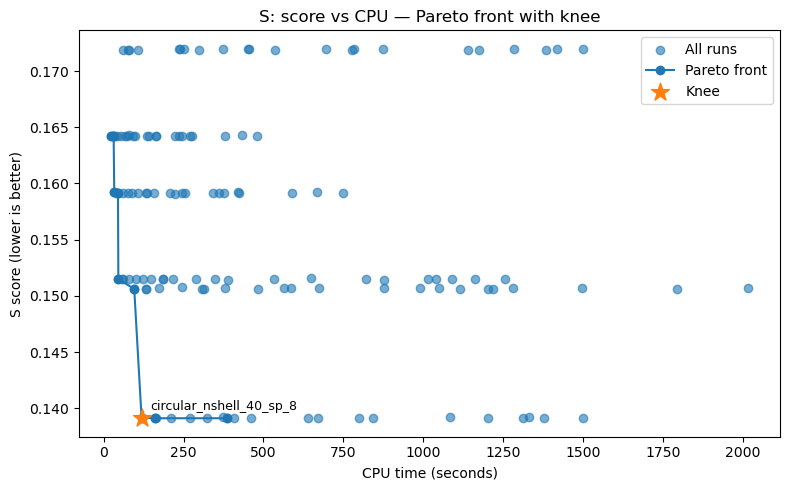

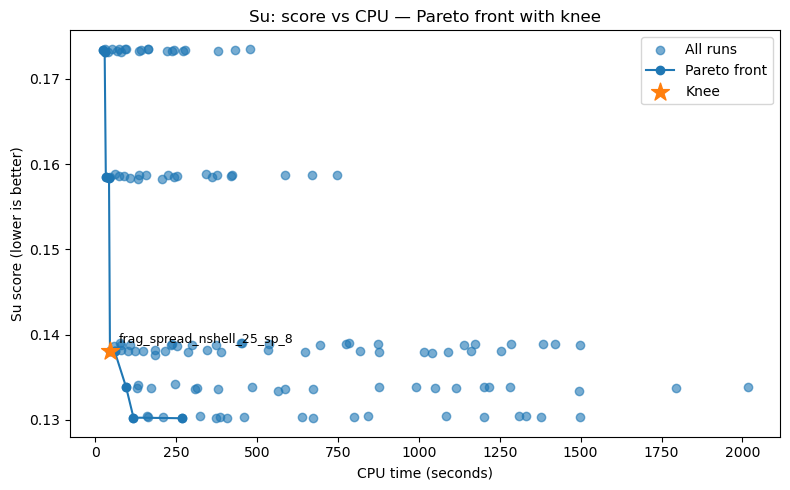

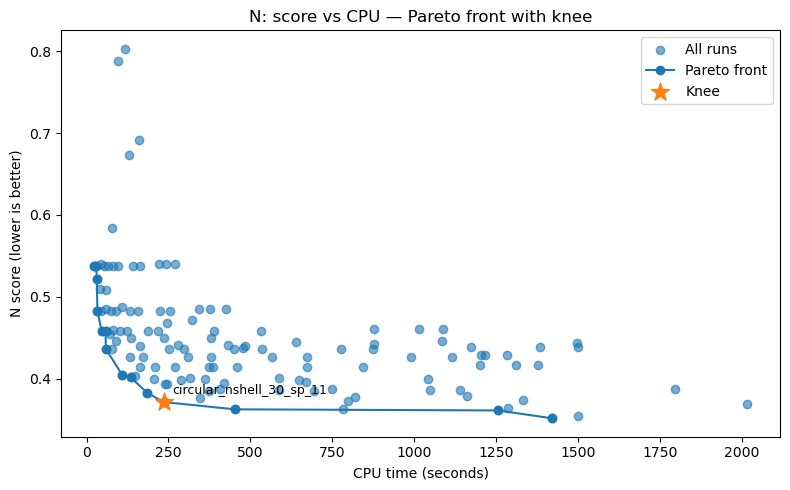

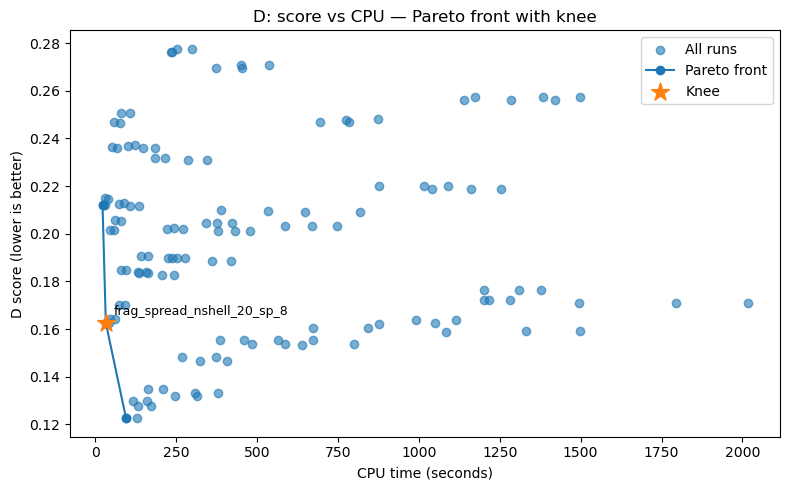

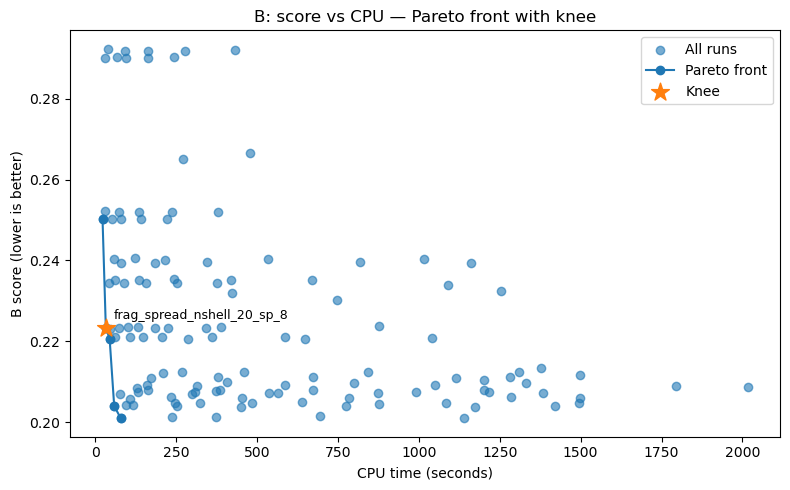

Saved per-species plots:
 - S: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_S.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_S.pdf
 - Su: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_Su.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_Su.pdf
 - N: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_N.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_N.pdf
 - D: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_D.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_D.pdf
 - B: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_B.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto/pareto_B.pdf


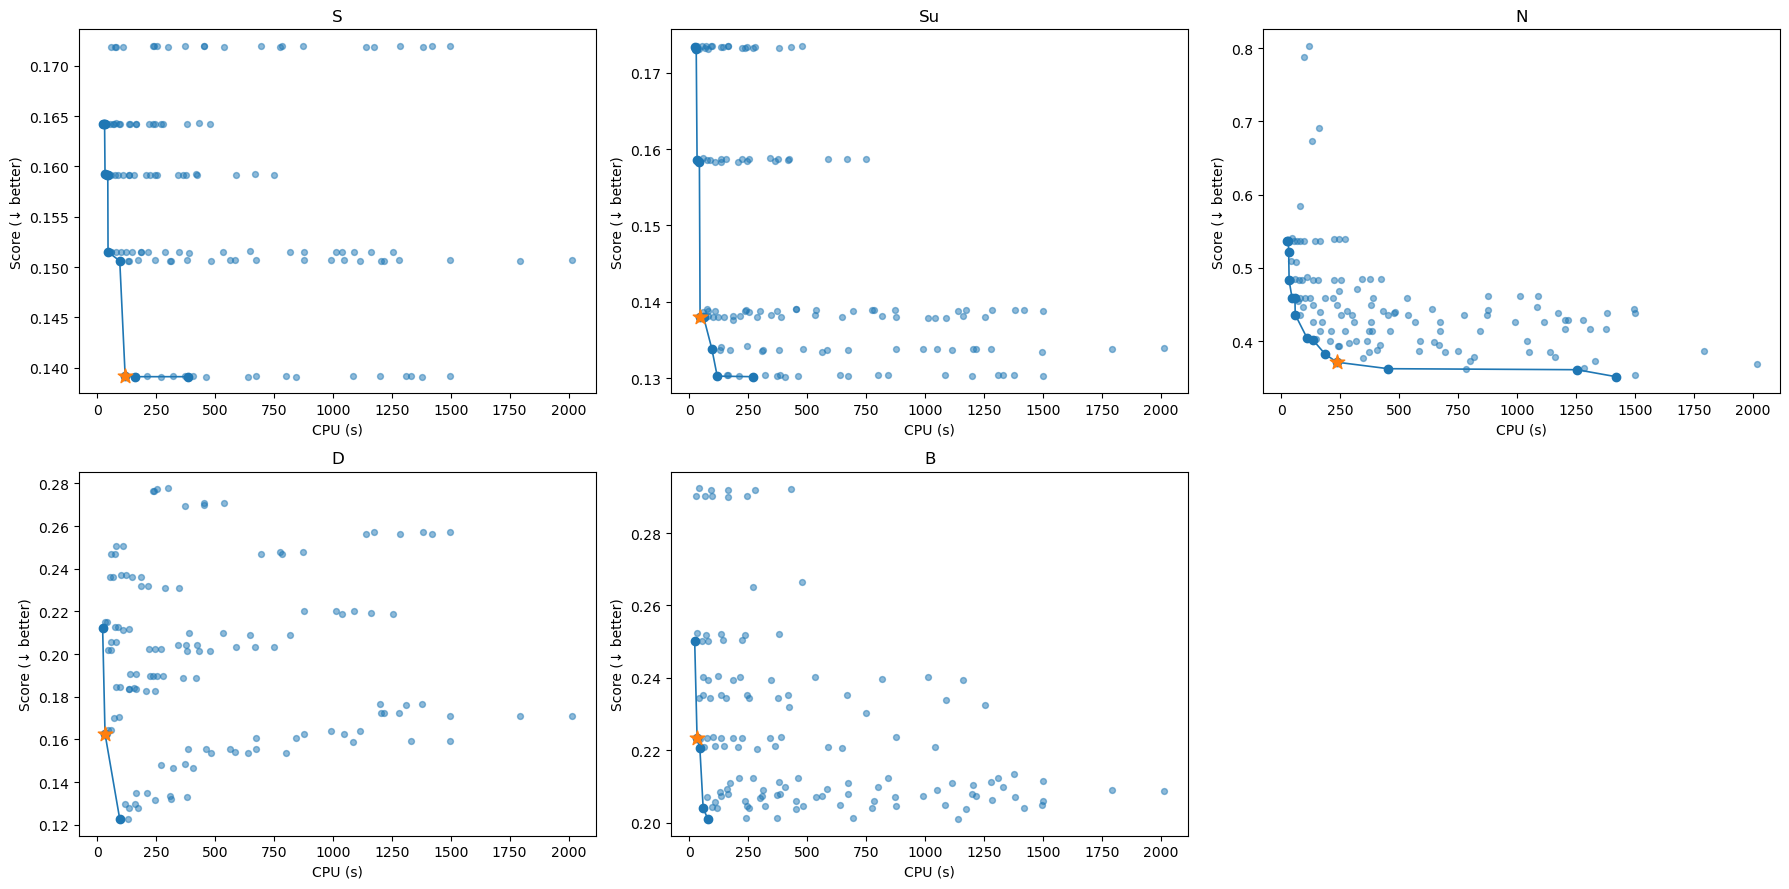

In [9]:
# --- CONFIG ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/per_species_pareto'
use_logx = False   # set True if CPU spans orders of magnitude

# --- Imports (NB: matplotlib only, no seaborn) ---
import os, re, csv, glob, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

os.makedirs(outdir, exist_ok=True)

# ---------- Load data ----------
cpu_df_path = f'{root}/all_scenario_scores_with_cpu.csv'
grp_df_path = f'{root}/all_group_metrics.csv'

if not os.path.exists(cpu_df_path):
    raise FileNotFoundError(cpu_df_path)
if not os.path.exists(grp_df_path):
    # Fallback: collect metrics_<scenario>.csv from each folder
    rows = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if not os.path.isdir(p): continue
        mpath = os.path.join(p, f'metrics_{d}.csv')
        if os.path.exists(mpath):
            tmp = pd.read_csv(mpath)
            tmp['simulation_name'] = d
            rows.append(tmp[['simulation_name','Group','Score_group']])
    if not rows:
        raise FileNotFoundError("No per-scenario metrics found.")
    group_df = pd.concat(rows, ignore_index=True)
else:
    group_df = pd.read_csv(grp_df_path)

cpu_df = pd.read_csv(cpu_df_path)[['simulation_name','cpu_seconds']]

df = (group_df.rename(columns={'Group':'species','Score_group':'score'})
               .merge(cpu_df, on='simulation_name', how='left'))
df = df[np.isfinite(df['score']) & np.isfinite(df['cpu_seconds'])]
species_list = [s for s in ['S','Su','N','D','B'] if s in set(df['species'])]  # keep order if present

# ---------- Pareto & knee helpers (minimize both axes) ----------
def pareto_indices(points: np.ndarray) -> np.ndarray:
    if points.size == 0: return np.array([], dtype=int)
    order = np.lexsort((points[:,1], points[:,0]))  # sort by cpu, then score
    pts = points[order]
    keep, best = [], np.inf
    for i, (_, sc) in enumerate(pts):
        if sc <= best + 1e-12:
            keep.append(i)
            best = sc if sc < best else best
    return order[np.array(keep, dtype=int)]

def knee_index(front_xy: np.ndarray):
    M = len(front_xy)
    if M < 3: return None
    x, y = front_xy[:,0].astype(float), front_xy[:,1].astype(float)
    x0, x1, y0, y1 = x.min(), x.max(), y.min(), y.max()
    if (x1 - x0) <= 0 or (y1 - y0) <= 0: return None
    xn, yn = (x - x0)/(x1 - x0), (y - y0)/(y1 - y0)
    p0, p1 = np.array([xn[0], yn[0]]), np.array([xn[-1], yn[-1]])
    v = p1 - p0; vn = np.linalg.norm(v)
    if vn <= 1e-12: return None
    P = np.stack([xn, yn], axis=1)
    d = np.abs(np.cross(v, P - p0))/vn
    return int(np.argmax(d))

# ---------- Per-species plots ----------
saved = []
for sp in species_list:
    dsp = df[df['species'] == sp].copy()
    if dsp.empty: continue

    pts = dsp[['cpu_seconds','score']].to_numpy(float)
    idx = pareto_indices(pts)
    front = pts[idx]
    order = np.argsort(front[:,0]) if len(front) else np.array([], int)
    idx = idx[order]; front = front[order]

    k = knee_index(front) if len(front) else None

    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(dsp['cpu_seconds'], dsp['score'], alpha=0.6, label='All runs')
    if len(front):
        ax.plot(front[:,0], front[:,1], marker='o', lw=1.5, label='Pareto front')
    if k is not None:
        ax.scatter([front[k,0]],[front[k,1]], marker='*', s=180, label='Knee', zorder=5)
        # annotate scenario at knee
        kmask = (np.isclose(dsp['cpu_seconds'], front[k,0]) & np.isclose(dsp['score'], front[k,1]))
        if kmask.any():
            kname = dsp.loc[kmask, 'simulation_name'].iloc[0]
            ax.annotate(kname, (front[k,0], front[k,1]), xytext=(6,6), textcoords='offset points', fontsize=9)

    if use_logx:
        ax.set_xscale('log')
    ax.set_xlabel('CPU time (seconds)')
    ax.set_ylabel(f'{sp} score (lower is better)')
    ax.set_title(f'{sp}: score vs CPU — Pareto front with knee')
    ax.legend()
    fig.tight_layout()

    png = os.path.join(outdir, f'pareto_{sp}.png')
    pdf = os.path.join(outdir, f'pareto_{sp}.pdf')
    fig.savefig(png, dpi=180); fig.savefig(pdf)
    plt.show()
    saved.append((sp, png, pdf))

print("Saved per-species plots:")
for sp, png, pdf in saved:
    print(f" - {sp}: {png} ; {pdf}")

# ---------- Optional: compact multi-panel figure ----------
cols = min(3, max(1, len(species_list)))
rows = (len(species_list) + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows), squeeze=False)

for ax, sp in zip(axes.ravel(), species_list):
    dsp = df[df['species'] == sp]
    pts = dsp[['cpu_seconds','score']].to_numpy(float)
    idx = pareto_indices(pts); front = pts[idx]
    order = np.argsort(front[:,0]) if len(front) else np.array([], int)
    idx = idx[order]; front = front[order]
    k = knee_index(front) if len(front) else None

    ax.scatter(dsp['cpu_seconds'], dsp['score'], alpha=0.5, s=18)
    if len(front): ax.plot(front[:,0], front[:,1], marker='o', lw=1.2)
    if k is not None: ax.scatter([front[k,0]],[front[k,1]], marker='*', s=120, zorder=5)
    if use_logx: ax.set_xscale('log')
    ax.set_title(sp); ax.set_xlabel('CPU (s)'); ax.set_ylabel('Score (↓ better)')

# hide unused axes
for ax in axes.ravel()[len(species_list):]:
    ax.axis('off')

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'pareto_all_species.png'), dpi=200)
fig.savefig(os.path.join(outdir, 'pareto_all_species.pdf'))
plt.show()

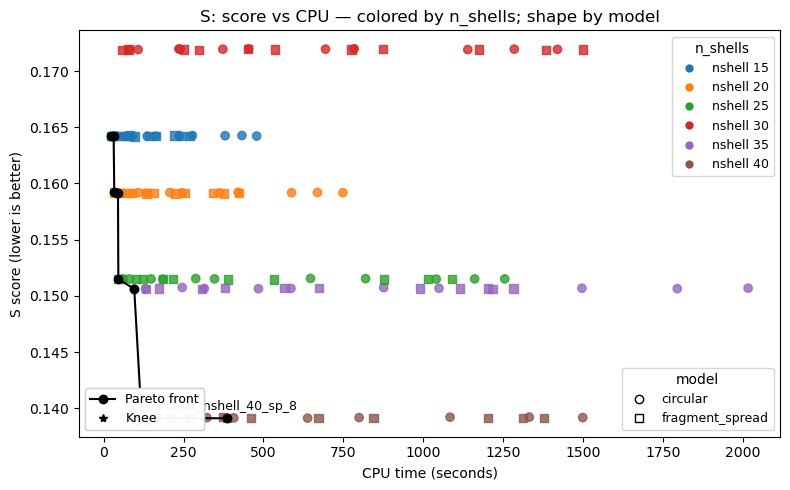

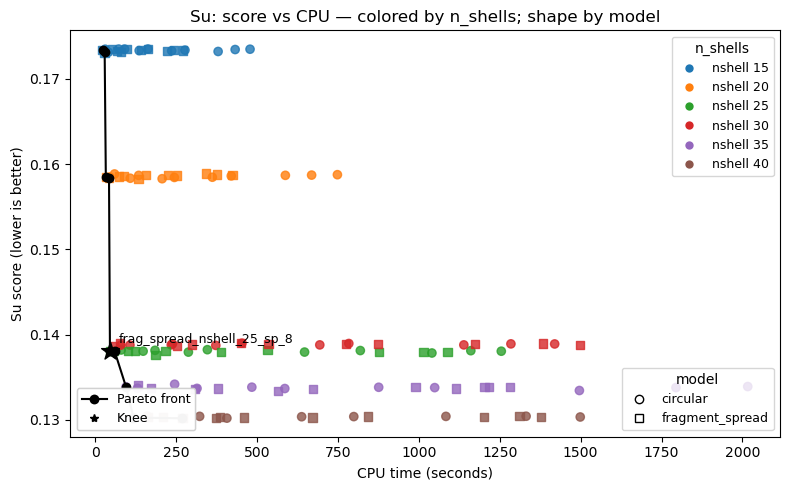

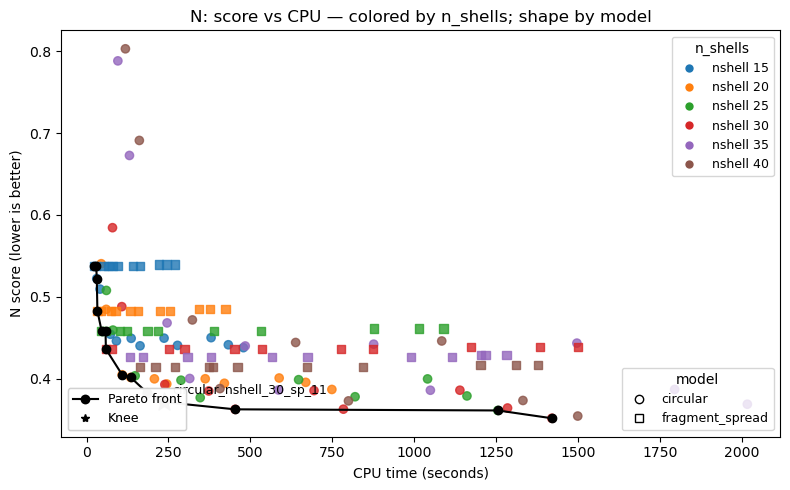

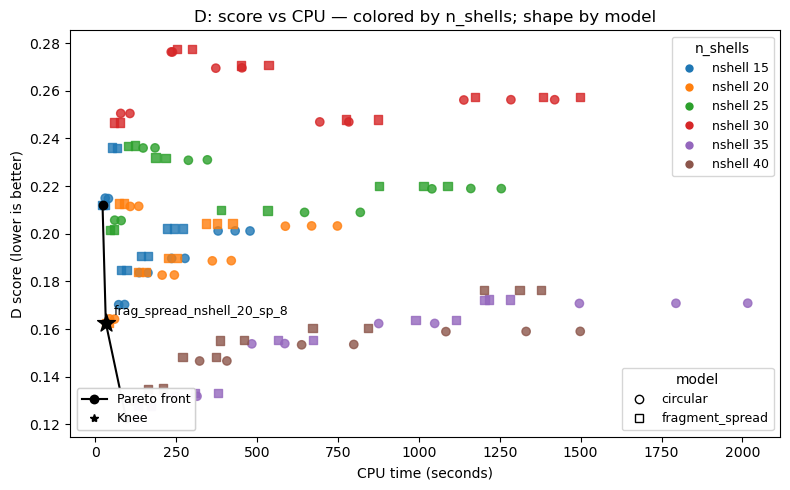

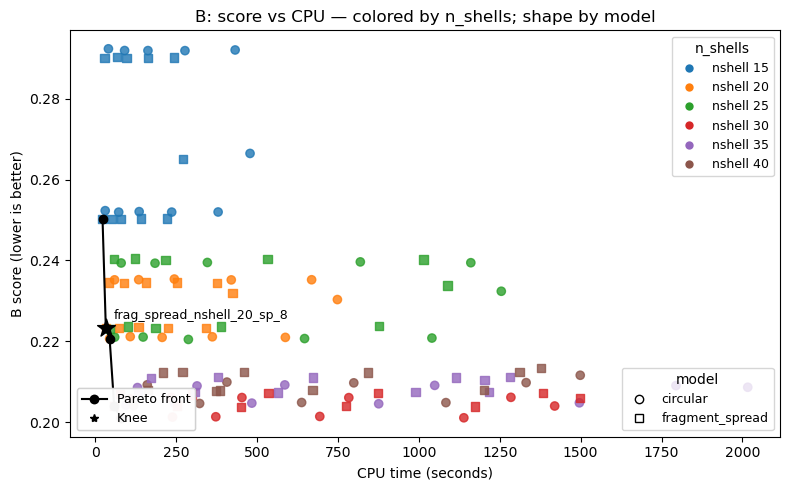

Saved per-species n_shell-colored plots:
 - S: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_S_nshell_colored.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_S_nshell_colored.pdf
 - Su: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_Su_nshell_colored.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_Su_nshell_colored.pdf
 - N: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_N_nshell_colored.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_N_nshell_colored.pdf
 - D: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_D_nshell_colored.png ; /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored/pareto_D_nshell_colored.pdf
 - B: /Users/indigob

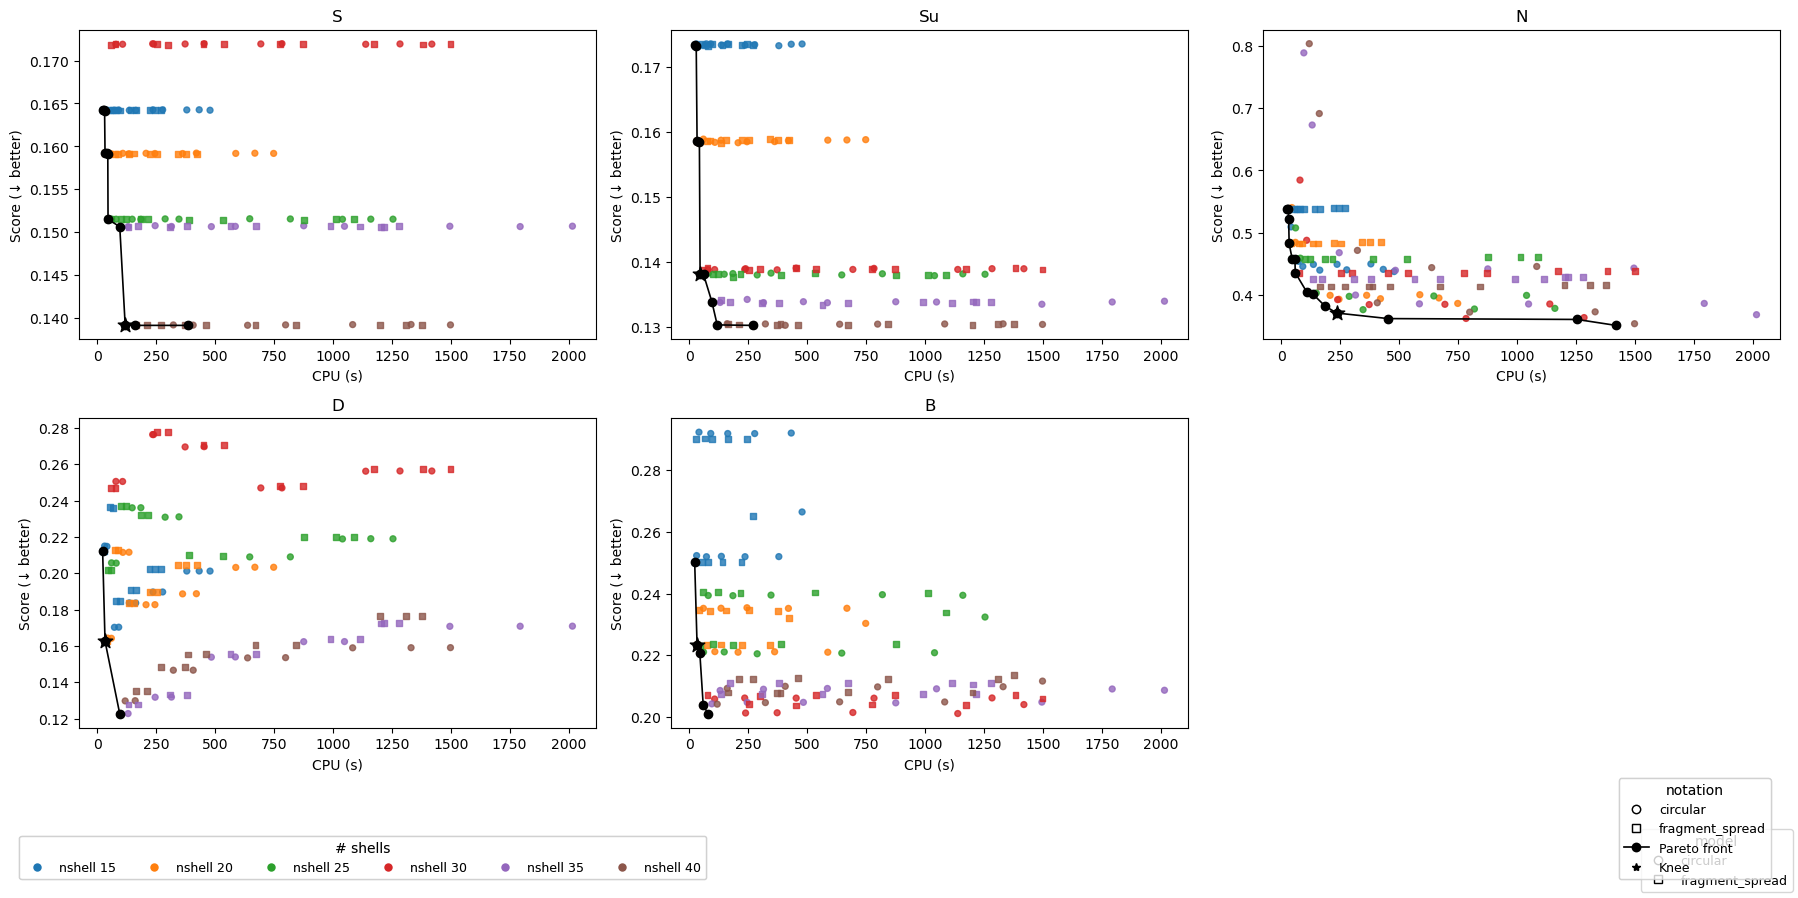

In [3]:
# --- CONFIG ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/per_species_pareto_nshell_colored'
use_logx = False   # set True if CPU spans orders of magnitude

# --- Imports ---
import os, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

os.makedirs(outdir, exist_ok=True)

# ---------- Load data ----------
cpu_df = pd.read_csv(f'{root}/all_scenario_scores_with_cpu.csv')[['simulation_name','cpu_seconds']]

try:
    group_df = pd.read_csv(f'{root}/all_group_metrics.csv')
    group_df = group_df.rename(columns={'Group':'species','Score_group':'score'})
    group_df = group_df[['simulation_name','species','score']]
except FileNotFoundError:
    # fallback: scrape per-folder metrics
    rows = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if not os.path.isdir(p): 
            continue
        mpath = os.path.join(p, f'metrics_{d}.csv')
        if os.path.exists(mpath):
            tmp = pd.read_csv(mpath)
            tmp['simulation_name'] = d
            tmp = tmp.rename(columns={'Group':'species','Score_group':'score'})
            rows.append(tmp[['simulation_name','species','score']])
    if not rows:
        raise FileNotFoundError("No per-scenario metrics found.")
    group_df = pd.concat(rows, ignore_index=True)

df = group_df.merge(cpu_df, on='simulation_name', how='left')

# --- NEW: parse model type (circular vs fragment spread) from simulation_name ---
# Treat anything matching 'frag[_-]?spread' (case-insensitive) as fragment_spread, else circular.
is_frag = df['simulation_name'].astype(str).str.contains(r'frag[_-]?spread', case=False, na=False)
df['model_type'] = np.where(is_frag, 'frag_spread', 'circular')

# parse n_shells from simulation_name, e.g. "..._nshell_20..."
df['n_shells'] = (
    df['simulation_name']
      .astype(str)
      .str.extract(r'_nshell_(\d+)', expand=False)
      .astype('float')
      .astype('Int64')
)
df = df[np.isfinite(df['score']) & np.isfinite(df['cpu_seconds']) & df['n_shells'].notna()]
df['n_shells'] = df['n_shells'].astype(int)

species_list = [s for s in ['S','Su','N','D','B'] if s in set(df['species'])]

# ---------- Pareto & knee helpers (minimize both axes) ----------
def pareto_indices(points: np.ndarray) -> np.ndarray:
    if points.size == 0: return np.array([], dtype=int)
    order = np.lexsort((points[:,1], points[:,0]))  # sort by cpu, then score
    pts = points[order]
    keep, best = [], np.inf
    for i, (_, sc) in enumerate(pts):
        if sc <= best + 1e-12:
            keep.append(i)
            best = sc if sc < best else best
    return order[np.array(keep, dtype=int)]

def knee_index(front_xy: np.ndarray):
    M = len(front_xy)
    if M < 3: return None
    x, y = front_xy[:,0].astype(float), front_xy[:,1].astype(float)
    x0, x1, y0, y1 = x.min(), x.max(), y.min(), y.max()
    if (x1 - x0) <= 0 or (y1 - y0) <= 0: return None
    xn, yn = (x - x0)/(x1 - x0), (y - y0)/(y1 - y0)
    p0, p1 = np.array([xn[0], yn[0]]), np.array([xn[-1], yn[-1]])
    v = p1 - p0; vn = np.linalg.norm(v)
    if vn <= 1e-12: return None
    P = np.stack([xn, yn], axis=1)
    d = np.abs(np.cross(v, P - p0))/vn
    return int(np.argmax(d))

# ---------- Helper for discrete color legend by n_shells ----------
def prep_color_map(nshell_values):
    base = plt.get_cmap('tab20' if len(nshell_values) > 10 else 'tab10')
    cols = [base(i % base.N) for i in range(len(nshell_values))]
    cmap = ListedColormap(cols)
    ns2idx = {ns:i for i, ns in enumerate(nshell_values)}
    return cmap, ns2idx

# ---------- Per-species plots ----------
saved = []
for sp in species_list:
    dsp = df[df['species'] == sp].copy()
    if dsp.empty: 
        continue

    ns_unique = sorted(dsp['n_shells'].unique().tolist())
    cmap, ns2idx = prep_color_map(ns_unique)

    # split by model type for different markers
    dsp_circ = dsp[dsp['model_type'] == 'circular']
    dsp_frag = dsp[dsp['model_type'] != 'circular']  # frag_spread

    color_idx_circ = dsp_circ['n_shells'].map(ns2idx).to_numpy(int)
    color_idx_frag = dsp_frag['n_shells'].map(ns2idx).to_numpy(int)

    pts = dsp[['cpu_seconds','score']].to_numpy(float)
    idx = pareto_indices(pts)
    front = pts[idx]
    order = np.argsort(front[:,0]) if len(front) else np.array([], int)
    idx = idx[order]; front = front[order]
    k = knee_index(front) if len(front) else None

    fig, ax = plt.subplots(figsize=(8,5))

    # --- scatter by model type: circle for circular, square for fragment_spread
    if not dsp_circ.empty:
        ax.scatter(dsp_circ['cpu_seconds'], dsp_circ['score'],
                   c=color_idx_circ, cmap=cmap, vmin=-0.5, vmax=len(ns_unique)-0.5,
                   alpha=0.8, marker='o', label='_nolegend_')
    if not dsp_frag.empty:
        ax.scatter(dsp_frag['cpu_seconds'], dsp_frag['score'],
                   c=color_idx_frag, cmap=cmap, vmin=-0.5, vmax=len(ns_unique)-0.5,
                   alpha=0.8, marker='s', label='_nolegend_')

    # Legend for n_shells (colors)
    color_handles = [
        Line2D([0],[0], marker='o', linestyle='None',
               markerfacecolor=cmap(ns2idx[ns]), markeredgecolor='none', label=f'nshell {ns}')
        for ns in ns_unique
    ]
    leg1 = ax.legend(handles=color_handles, title='n_shells', loc='upper right', fontsize=9)
    ax.add_artist(leg1)

    # Legend for model type (shapes)
    shape_handles = [
        Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='none',
               markeredgecolor='k', label='circular'),
        Line2D([0],[0], marker='s', linestyle='None', markerfacecolor='none',
               markeredgecolor='k', label='fragment_spread')
    ]
    leg2 = ax.legend(handles=shape_handles, title='model', loc='lower right', fontsize=9)
    ax.add_artist(leg2)

    # Pareto front & knee overlays (their own small legend)
    pareto_handles = []
    if len(front):
        ax.plot(front[:,0], front[:,1], marker='o', lw=1.5, color='k')
        pareto_handles.append(Line2D([0],[0], color='k', marker='o', label='Pareto front'))
    if k is not None:
        ax.scatter([front[k,0]],[front[k,1]], marker='*', s=180, color='k', zorder=5)
        pareto_handles.append(Line2D([0],[0], marker='*', linestyle='None', color='k', label='Knee'))
        # annotate scenario at knee
        kmask = (np.isclose(dsp['cpu_seconds'], front[k,0]) & np.isclose(dsp['score'], front[k,1]))
        if kmask.any():
            kname = dsp.loc[kmask, 'simulation_name'].iloc[0]
            ax.annotate(kname, (front[k,0], front[k,1]), xytext=(6,6), textcoords='offset points', fontsize=9)
    if pareto_handles:
        leg3 = ax.legend(handles=pareto_handles, loc='lower left', fontsize=9)
        ax.add_artist(leg3)

    if use_logx:
        ax.set_xscale('log')
    ax.set_xlabel('CPU time (seconds)')
    ax.set_ylabel(f'{sp} score (lower is better)')
    ax.set_title(f'{sp}: score vs CPU — colored by n_shells; shape by model')
    fig.tight_layout()

    png = os.path.join(outdir, f'pareto_{sp}_nshell_colored.png')
    pdf = os.path.join(outdir, f'pareto_{sp}_nshell_colored.pdf')
    fig.savefig(png, dpi=180); fig.savefig(pdf)
    plt.show()
    saved.append((sp, png, pdf))

print("Saved per-species n_shell-colored plots:")
for sp, png, pdf in saved:
    print(f" - {sp}: {png} ; {pdf}")

# ---------- Optional: compact multi-panel summary ----------
cols = min(3, max(1, len(species_list)))
rows = (len(species_list) + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows), squeeze=False)

for ax, sp in zip(axes.ravel(), species_list):
    dsp = df[df['species'] == sp]
    if dsp.empty: 
        ax.axis('off'); 
        continue
    ns_unique = sorted(dsp['n_shells'].unique().tolist())
    cmap, ns2idx = prep_color_map(ns_unique)

    dsp_circ = dsp[dsp['model_type'] == 'circular']
    dsp_frag = dsp[dsp['model_type'] != 'circular']

    color_idx_circ = dsp_circ['n_shells'].map(ns2idx).to_numpy(int)
    color_idx_frag = dsp_frag['n_shells'].map(ns2idx).to_numpy(int)

    pts = dsp[['cpu_seconds','score']].to_numpy(float)
    idx = pareto_indices(pts); front = pts[idx]
    order = np.argsort(front[:,0]) if len(front) else np.array([], int)
    idx = idx[order]; front = front[order]
    k = knee_index(front) if len(front) else None

    if not dsp_circ.empty:
        ax.scatter(dsp_circ['cpu_seconds'], dsp_circ['score'],
                   c=color_idx_circ, cmap=cmap, vmin=-0.5, vmax=len(ns_unique)-0.5,
                   s=18, alpha=0.8, marker='o')
    if not dsp_frag.empty:
        ax.scatter(dsp_frag['cpu_seconds'], dsp_frag['score'],
                   c=color_idx_frag, cmap=cmap, vmin=-0.5, vmax=len(ns_unique)-0.5,
                   s=18, alpha=0.8, marker='s')

    if len(front): ax.plot(front[:,0], front[:,1], marker='o', lw=1.2, color='k')
    if k is not None: ax.scatter([front[k,0]],[front[k,1]], marker='*', s=120, color='k', zorder=5)
    if use_logx: ax.set_xscale('log')
    ax.set_title(sp); ax.set_xlabel('CPU (s)'); ax.set_ylabel('Score (↓ better)')

# hide unused axes
for ax in axes.ravel()[len(species_list):]:
    ax.axis('off')

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'pareto_all_species_nshell_colored.png'), dpi=200)
fig.savefig(os.path.join(outdir, 'pareto_all_species_nshell_colored.pdf'))

# (Optional) a small figure-level legend for shapes
# --- Figure-level legend for shapes (circles = circular, squares = fragment_spread)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='none', markeredgecolor='k', label='circular'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='none', markeredgecolor='k', label='fragment_spread')
]

fig.legend(handles=shape_handles,
           # labels are optional if handles have 'label=' set:
           # labels=['circular', 'fragment_spread'],
           title='model',
           loc='lower right',
           fontsize=9)

# --- Build global legend handles ---
# Colors for n_shells across the WHOLE dataframe
nshell_values = sorted(df['n_shells'].unique().tolist())
cmap_all, ns2idx_all = prep_color_map(nshell_values)
nshell_handles = [
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor=cmap_all(i), markeredgecolor='none',
           label=f'nshell {ns}')
    for i, ns in enumerate(nshell_values)
]

# Shapes for model type
shape_handles = [
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor='none', markeredgecolor='k', label='circular'),
    Line2D([0],[0], marker='s', linestyle='None',
           markerfacecolor='none', markeredgecolor='k', label='fragment_spread')
]

# Pareto front + knee glyphs
pareto_handle = Line2D([0],[0], color='k', lw=1.2, marker='o', label='Pareto front')
knee_handle   = Line2D([0],[0], color='k', marker='*', linestyle='None', label='Knee')

# --- Leave space at the bottom for legends (important if using tight_layout)
fig.tight_layout(rect=(0, 0.12, 1, 1))  # reserve ~12% at bottom

# --- Two separate figure-level legends ---
leg_colors = fig.legend(handles=nshell_handles,
                        title='# shells',
                        loc='lower left', bbox_to_anchor=(0.01, 0.01),
                        ncol=min(6, len(nshell_handles)), fontsize=9)

leg_markup = fig.legend(handles=shape_handles + [pareto_handle, knee_handle],
                        title='notation',
                        loc='lower right', bbox_to_anchor=(0.99, 0.01),
                        ncol=1, fontsize=9)

# Keep both legends on the figure
fig.add_artist(leg_colors)
fig.add_artist(leg_markup)

plt.show()

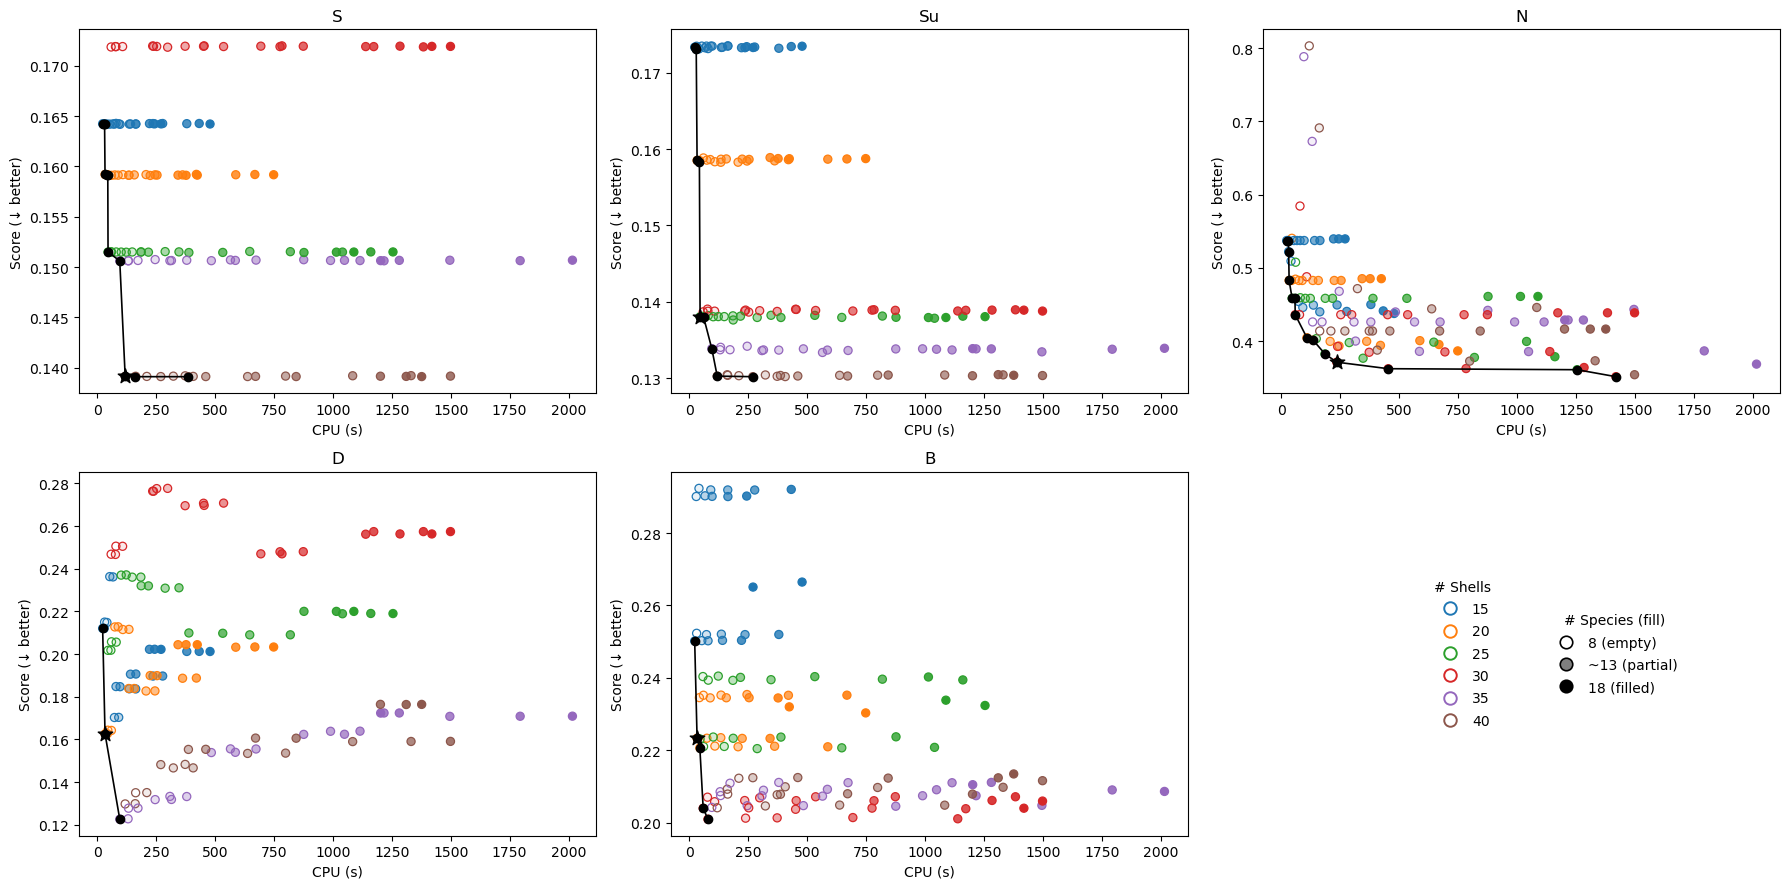

Saved figure to: /Users/indigobrownhall/Code/pyssem/grid_search_new/per_species_pareto_nshell_colored


In [35]:
# -*- coding: utf-8 -*-
# Per-species multi-panel plot:
# - edge color encodes # shells (n_shells)
# - face fill encodes # species (n_species): empty → partial → filled
# - includes Pareto front + knee
# - legend occupies the last (empty) subplot cell, shown as two tidy columns

# --- CONFIG ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/per_species_pareto_nshell_colored'

# --- Imports ---
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

os.makedirs(outdir, exist_ok=True)

# ---------- Load data ----------
cpu_df = pd.read_csv(f'{root}/all_scenario_scores_with_cpu.csv')[['simulation_name','cpu_seconds']]

try:
    group_df = pd.read_csv(f'{root}/all_group_metrics.csv')
    group_df = group_df.rename(columns={'Group':'species','Score_group':'score'})
    group_df = group_df[['simulation_name','species','score']]
except FileNotFoundError:
    # fallback: scrape per-folder metrics
    rows = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if not os.path.isdir(p):
            continue
        mpath = os.path.join(p, f'metrics_{d}.csv')
        if os.path.exists(mpath):
            tmp = pd.read_csv(mpath)
            tmp['simulation_name'] = d
            tmp = tmp.rename(columns={'Group':'species','Score_group':'score'})
            rows.append(tmp[['simulation_name','species','score']])
    if not rows:
        raise FileNotFoundError("No per-scenario metrics found.")
    group_df = pd.concat(rows, ignore_index=True)

df = group_df.merge(cpu_df, on='simulation_name', how='left')

# parse n_shells and n_species from simulation_name, e.g. "..._nshell_20_sp_13"
df['n_shells'] = (
    df['simulation_name'].astype(str)
      .str.extract(r'_nshell_(\d+)', expand=False)
      .astype('float').astype('Int64')
)
df['n_species'] = (
    df['simulation_name'].astype(str)
      .str.extract(r'_sp_(\d+)', expand=False)
      .astype('float')
)

# keep valid rows
df = df[np.isfinite(df['score']) & np.isfinite(df['cpu_seconds']) & df['n_shells'].notna()]
df['n_shells'] = df['n_shells'].astype(int)

species_list = [s for s in ['S','Su','N','D','B'] if s in set(df['species'])]

# ---------- Helpers ----------
def prep_color_map(nshell_values):
    base = plt.get_cmap('tab20' if len(nshell_values) > 10 else 'tab10')
    cols = [base(i % base.N) for i in range(len(nshell_values))]
    cmap = ListedColormap(cols)
    ns2idx = {ns:i for i, ns in enumerate(nshell_values)}
    return cmap, ns2idx

def pareto_indices(points: np.ndarray) -> np.ndarray:
    if points.size == 0: return np.array([], dtype=int)
    order = np.lexsort((points[:,1], points[:,0]))  # sort by cpu, then score
    pts = points[order]
    keep, best = [], np.inf
    for i, (_, sc) in enumerate(pts):
        if sc <= best + 1e-12:
            keep.append(i)
            best = sc if sc < best else best
    return order[np.array(keep, dtype=int)]

def knee_index(front_xy: np.ndarray):
    M = len(front_xy)
    if M < 3: return None
    x, y = front_xy[:,0].astype(float), front_xy[:,1].astype(float)
    x0, x1, y0, y1 = x.min(), x.max(), y.min(), y.max()
    if (x1 - x0) <= 0 or (y1 - y0) <= 0: return None
    xn, yn = (x - x0)/(x1 - x0 + 1e-12), (y - y0)/(y1 - y0 + 1e-12)
    p0, p1 = np.array([xn[0], yn[0]]), np.array([xn[-1], yn[-1]])
    v = p1 - p0; vn = np.linalg.norm(v)
    if vn <= 1e-12: return None
    P = np.stack([xn, yn], axis=1)
    d = np.abs(np.cross(v, P - p0))/vn
    return int(np.argmax(d))

# --- Color by n_shells (consistent across panels) ---
ns_unique_global = sorted(df['n_shells'].dropna().astype(int).unique().tolist())
cmap_global, ns2idx_global = prep_color_map(ns_unique_global)

# --- Face fill alpha by n_species (normalize across all data) ---
ns_vals_global = df['n_species'].dropna().astype(float)
alpha_min, alpha_max = 0.00, 1.00   # 0 → empty circle, 1 → fully filled
ns_min = float(ns_vals_global.min()) if not ns_vals_global.empty else 1.0
ns_max = float(ns_vals_global.max()) if not ns_vals_global.empty else 1.0
ns_range = max(ns_max - ns_min, 1e-12)

def fill_alpha(v):
    if np.isnan(v):
        return 0.5 * (alpha_min + alpha_max)
    return alpha_min + (float(v) - ns_min) / ns_range * (alpha_max - alpha_min)

# --- Grid with one extra cell reserved for the legend (bottom-right) ---
cols = 3
rows = math.ceil((len(species_list) + 1) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.5*rows), squeeze=False)

# --- Per-species panels ---
for ax, sp in zip(axes.ravel(), species_list):
    dsp = df[df['species'] == sp].copy()
    if dsp.empty:
        ax.axis('off'); 
        continue

    # Edge colors by n_shells; face alpha by n_species
    edge_idx = dsp['n_shells'].map(ns2idx_global).to_numpy(int)
    edge_cols = cmap_global(edge_idx)  # Nx4 RGBA

    face_cols = edge_cols.copy()
    alphas = dsp['n_species'].astype(float).apply(fill_alpha).to_numpy(float)
    face_cols[:, 3] = alphas

    ax.scatter(dsp['cpu_seconds'], dsp['score'],
               facecolors=face_cols, edgecolors=edge_cols,
               linewidths=0.9, s=34)

    # Pareto front + knee
    pts = dsp[['cpu_seconds','score']].to_numpy(float)
    idx = pareto_indices(pts)
    front = pts[idx]
    if len(front):
        order = np.argsort(front[:,0])
        front = front[order]
        ax.plot(front[:,0], front[:,1], marker='o', lw=1.2, color='k')
        k = knee_index(front)
        if k is not None:
            ax.scatter([front[k,0]],[front[k,1]], marker='*', s=120, color='k', zorder=5)

    ax.set_title(sp)
    ax.set_xlabel('CPU (s)')
    ax.set_ylabel('Score (↓ better)')

# Turn off unused axes except the legend cell
total_cells = rows * cols
legend_cell_index = total_cells - 1
for i, ax in enumerate(axes.ravel()):
    if i >= len(species_list) and i != legend_cell_index:
        ax.axis('off')

# --- Legend in the reserved last cell (centered), two columns ---
ax_leg = axes.ravel()[legend_cell_index]
ax_leg.axis('off')

# Column 1: # Shells (edge color) — labels are just the numbers
shell_handles = [
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor='none',
           markeredgecolor=cmap_global(ns2idx_global[ns]),
           markeredgewidth=1.4, markersize=9,
           label=f'{ns}')
    for ns in ns_unique_global
]
shell_labels = [h.get_label() for h in shell_handles]

# Column 2: # Species (fill) — empty → partial → filled as a scale
min_sp = int(ns_min) if np.isfinite(ns_min) else None
max_sp = int(ns_max) if np.isfinite(ns_max) else None
mid_sp = int(round((ns_min + ns_max)/2.0)) if np.isfinite(ns_min) and np.isfinite(ns_max) else None

fill_handles = [
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor=(0,0,0,0.00), markeredgecolor='k',
           markeredgewidth=1.2, markersize=9,
           label=f'{min_sp} (empty)' if min_sp is not None else 'few (empty)'),
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor=(0,0,0,0.50), markeredgecolor='k',
           markeredgewidth=1.2, markersize=9,
           label=f'~{mid_sp} (partial)' if mid_sp is not None else 'median (partial)'),
    Line2D([0],[0], marker='o', linestyle='None',
           markerfacecolor=(0,0,0,1.00), markeredgecolor='k',
           markeredgewidth=1.2, markersize=9,
           label=f'{max_sp} (filled)' if max_sp is not None else 'many (filled)'),
]
fill_labels = [h.get_label() for h in fill_handles]

# how far apart the two legend blocks sit (smaller = closer)
GAP = 0.04                       # try 0.04 .. 0.15

left_x  = 0.5 - GAP              # center-left block (# Shells)
right_x = 0.5 + GAP              # center-right block (# Species)

leg_shells = ax_leg.legend(
    handles=shell_handles, labels=[h.get_label() for h in shell_handles],
    title='# Shells',
    loc='center right', bbox_to_anchor=(left_x, 0.5),   # << move this to change the gap
    frameon=False, fontsize=10,
    handletextpad=0.6, labelspacing=0.6, borderpad=0.2, columnspacing=1.0
)
ax_leg.add_artist(leg_shells)

ax_leg.legend(
    handles=fill_handles, labels=[h.get_label() for h in fill_handles],
    title='# Species (fill)',
    loc='center left', bbox_to_anchor=(right_x, 0.5),   # << and this
    frameon=False, fontsize=10,
    handletextpad=0.6, labelspacing=0.6, borderpad=0.2, columnspacing=1.0
)

fig.tight_layout()
fig.savefig(os.path.join(outdir, 'per_species_cpu_score_combined_fillBySpecies.png'), dpi=220)
fig.savefig(os.path.join(outdir, 'per_species_cpu_score_combined_fillBySpecies.pdf'))
plt.show()
print("Saved figure to:", outdir)

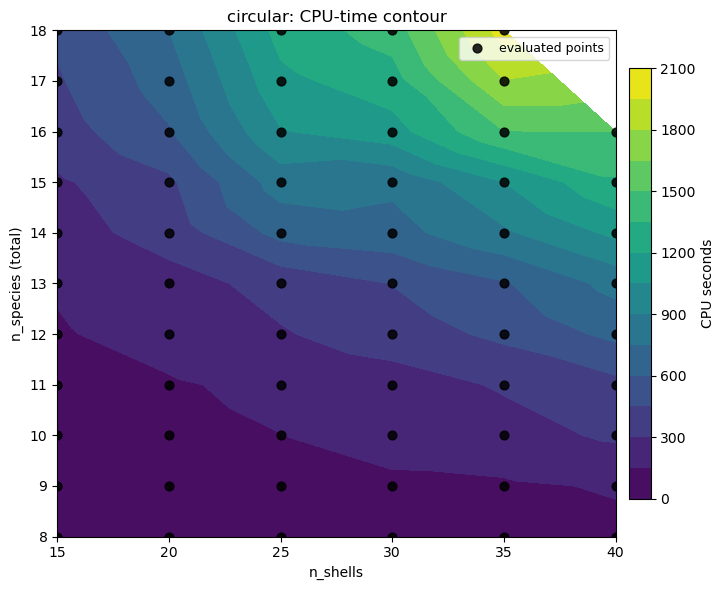

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_circular_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_circular_linear.pdf


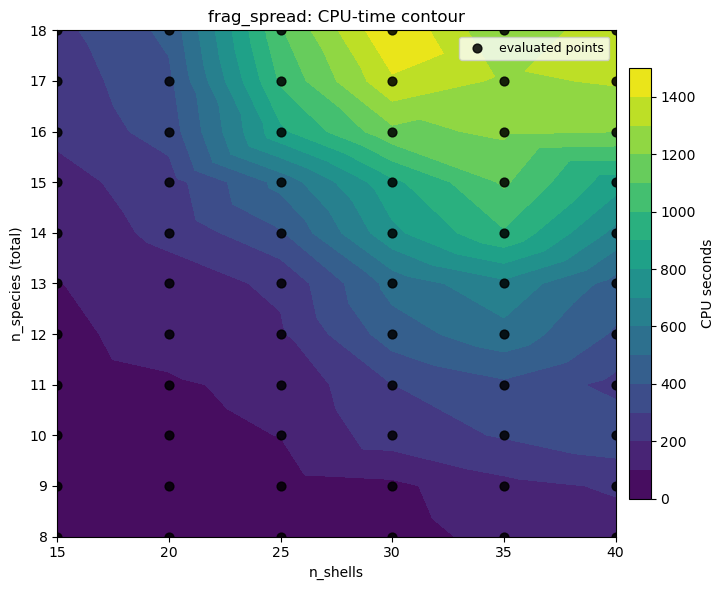

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_frag_spread_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_frag_spread_linear.pdf


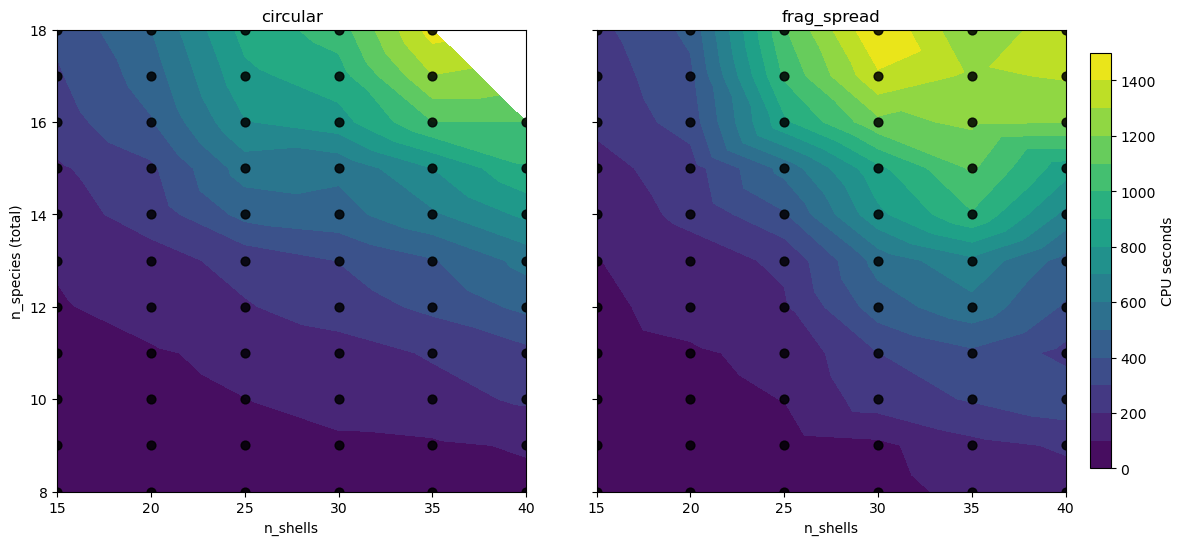

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_side_by_side_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_contour_side_by_side_linear.pdf


In [18]:
# --- paths ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/contours'
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.lines import Line2D
os.makedirs(outdir, exist_ok=True)

# --- load scenario table ---
scn = pd.read_csv(f'{root}/all_scenario_scores_with_cpu.csv')  # simulation_name, Score_scenario, cpu_seconds

def parse_name(name: str):
    mt = name.split('_nshell_')[0]
    m1 = re.search(r'_nshell_(\d+)', name)
    m2 = re.search(r'_sp_(\d+)', name)
    nshells  = int(m1.group(1)) if m1 else np.nan
    nspecies = int(m2.group(1)) if m2 else np.nan
    return mt, nshells, nspecies

parsed = scn['simulation_name'].apply(parse_name)
scn['model_type'] = [t[0] for t in parsed]
scn['n_shells']   = [t[1] for t in parsed]
scn['n_species']  = [t[2] for t in parsed]

# fallback if n_species wasn't encoded in the name but exists as a column
if scn['n_species'].isna().all() and 'species_count' in scn.columns:
    scn['n_species'] = scn['species_count']

scn = scn.dropna(subset=['cpu_seconds','n_shells','n_species'])
scn['n_shells']  = scn['n_shells'].astype(int)
scn['n_species'] = scn['n_species'].astype(int)

# --- single model plot (linear scale, no grid lines) ---
def plot_cpu_contour(df, model_type, levels=14):
    sub = df[df['model_type'] == model_type].copy()
    if sub.empty:
        print(f"[WARN] no rows for model_type='{model_type}'")
        return None

    sub_agg = (sub.groupby(['n_shells','n_species'], as_index=False)['cpu_seconds']
                 .median())

    x = sub_agg['n_shells'].to_numpy(float)
    y = sub_agg['n_species'].to_numpy(float)
    z = sub_agg['cpu_seconds'].to_numpy(float)

    tri = mtri.Triangulation(x, y)
    fig, ax = plt.subplots(figsize=(7.5, 6))
    cs = ax.tricontourf(tri, z, levels=levels)  # linear CPU scale
    cb = fig.colorbar(cs, ax=ax, shrink=0.85, pad=0.02)
    cb.set_label('CPU seconds')

    # sample points (legend inside for single plot)
    ax.scatter(x, y, s=40, c='k', alpha=0.85, label='evaluated points')
    ax.legend(loc='best', fontsize=9)

    ax.set_xticks(sorted(sub_agg['n_shells'].unique()))
    ax.set_yticks(sorted(sub_agg['n_species'].unique()))
    ax.set_xlabel('n_shells')
    ax.set_ylabel('n_species (total)')
    ax.set_title(f"{model_type}: CPU-time contour")

    fig.tight_layout()
    fn = f'{outdir}/cpu_contour_{model_type}_linear'
    fig.savefig(fn + '.png', dpi=200); fig.savefig(fn + '.pdf')
    plt.show()
    print(f"Wrote {fn+'.png'} and {fn+'.pdf'}")
    return fig

plot_cpu_contour(scn, 'circular')
plot_cpu_contour(scn, 'frag_spread')

# --- side-by-side (legend outside left, linear scale, no grid lines) ---
def side_by_side(df, types=('circular','frag_spread'), levels=14):
    fig, axes = plt.subplots(1, len(types), figsize=(7.5*len(types), 6), sharey=True)
    # leave room on the left for the outside legend
    fig.subplots_adjust(left=0.17, right=0.98, wspace=0.15)

    cs = None
    for ax, mt in zip(axes, types):
        sub = df[df['model_type']==mt].copy()
        if sub.empty:
            ax.set_axis_off(); continue
        sub_agg = (sub.groupby(['n_shells','n_species'], as_index=False)['cpu_seconds'].median())
        x = sub_agg['n_shells'].to_numpy(float)
        y = sub_agg['n_species'].to_numpy(float)
        z = sub_agg['cpu_seconds'].to_numpy(float)

        tri = mtri.Triangulation(x, y)
        cs = ax.tricontourf(tri, z, levels=levels)  # linear CPU scale
        ax.scatter(x, y, s=40, c='k', alpha=0.85)   # evaluated points
        ax.set_title(mt)
        ax.set_xlabel('n_shells')
        ax.set_xticks(sorted(sub_agg['n_shells'].unique()))

    axes[0].set_ylabel('n_species (total)')

    # shared colorbar
    cbar = fig.colorbar(cs, ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label('CPU seconds')

    # legend OUTSIDE LEFT
    # outside_legend = [Line2D([0],[0], marker='o', linestyle='None', color='k', label='evaluated points')]
    # anchor relative to first axes, just outside to the left
    # axes[0].legend(handles=outside_legend, loc='center left', bbox_to_anchor=(-0.25, 0.5),
    #                frameon=False, fontsize=10, title=None)

    # fig.suptitle('CPU-time contour by model type (linear scale)', y=1.02, fontsize=14)
    fn = f'{outdir}/cpu_contour_side_by_side_linear'
    fig.savefig(fn + '.png', dpi=200); fig.savefig(fn + '.pdf')
    plt.show()
    print(f"Wrote {fn+'.png'} and {fn+'.pdf'}")

side_by_side(scn, types=('circular','frag_spread'))

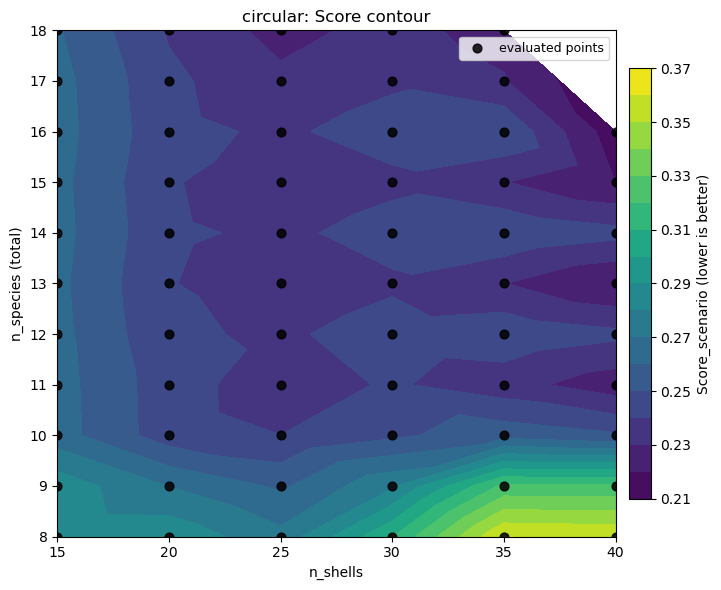

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_circular_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_circular_linear.pdf


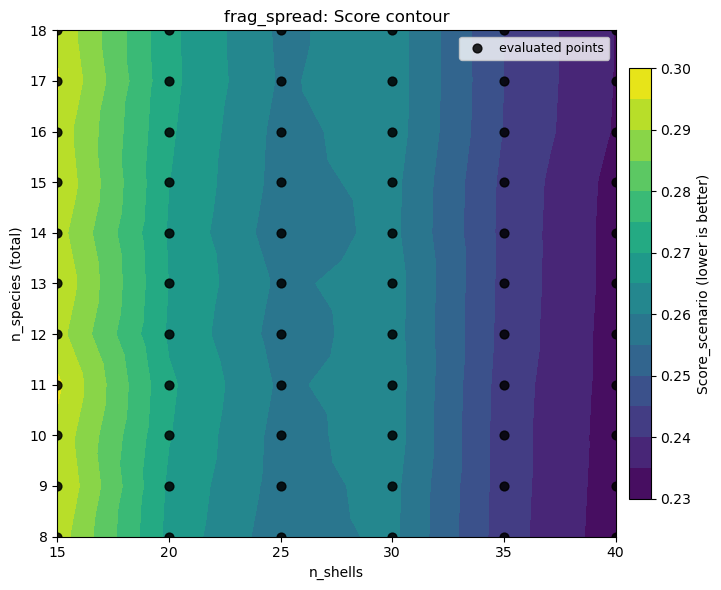

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_frag_spread_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_frag_spread_linear.pdf


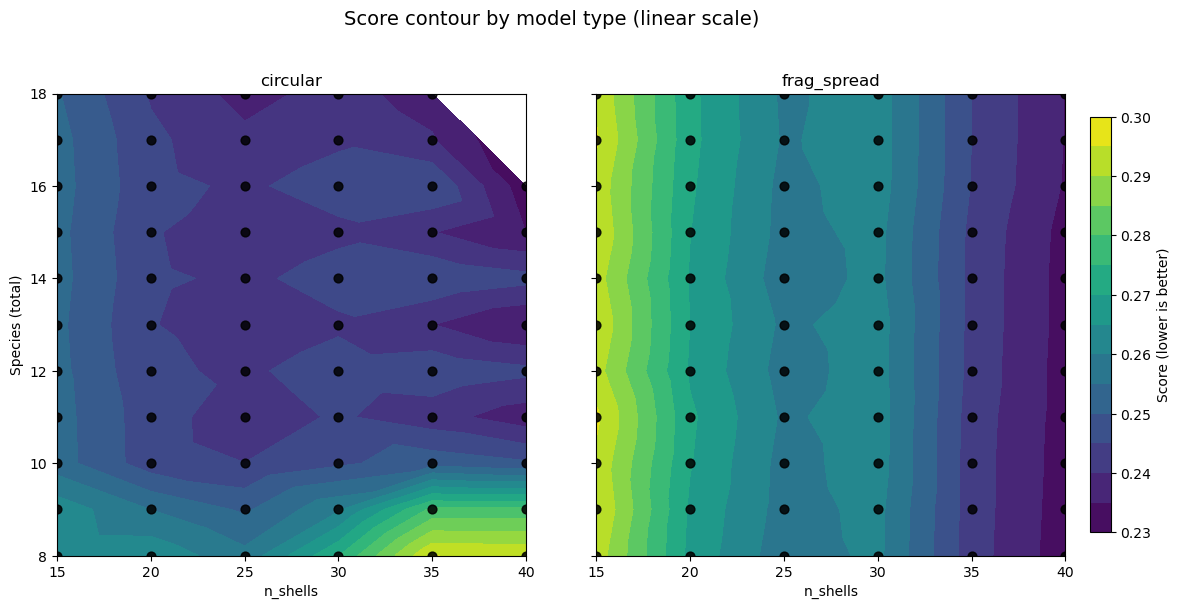

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_side_by_side_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/score_contour_side_by_side_linear.pdf


In [25]:
# --- paths ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/contours'
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.lines import Line2D
os.makedirs(outdir, exist_ok=True)

# --- load scenario table ---
scn = pd.read_csv(f'{root}/all_scenario_scores_with_cpu.csv')  # has: simulation_name, Score_scenario, cpu_seconds

def parse_name(name: str):
    mt = name.split('_nshell_')[0]
    m1 = re.search(r'_nshell_(\d+)', name)
    m2 = re.search(r'_sp_(\d+)', name)
    nshells  = int(m1.group(1)) if m1 else np.nan
    nspecies = int(m2.group(1)) if m2 else np.nan
    return mt, nshells, nspecies

p = scn['simulation_name'].apply(parse_name)
scn['model_type'] = [t[0] for t in p]
scn['n_shells']   = [t[1] for t in p]
scn['n_species']  = [t[2] for t in p]

# fallback if n_species not encoded but present as a column
if scn['n_species'].isna().all() and 'species_count' in scn.columns:
    scn['n_species'] = scn['species_count']

# keep only rows with factor info + score
scn = scn.dropna(subset=['Score_scenario','n_shells','n_species'])
scn['n_shells']  = scn['n_shells'].astype(int)
scn['n_species'] = scn['n_species'].astype(int)

# --- single model plot (Score) ---
def plot_score_contour(df, model_type, levels=14):
    sub = df[df['model_type'] == model_type].copy()
    if sub.empty:
        print(f"[WARN] no rows for model_type='{model_type}'")
        return None

    # median in case multiple runs share (n_shells, n_species)
    sub_agg = (sub.groupby(['n_shells','n_species'], as_index=False)['Score_scenario']
                 .median())

    x = sub_agg['n_shells'].to_numpy(float)
    y = sub_agg['n_species'].to_numpy(float)
    z = sub_agg['Score_scenario'].to_numpy(float)

    tri = mtri.Triangulation(x, y)
    fig, ax = plt.subplots(figsize=(7.5, 6))
    cs = ax.tricontourf(tri, z, levels=levels)  # linear score
    cb = fig.colorbar(cs, ax=ax, shrink=0.85, pad=0.02)
    cb.set_label('Score_scenario (lower is better)')

    # evaluated points
    ax.scatter(x, y, s=40, c='k', alpha=0.85, label='evaluated points')
    ax.legend(loc='best', fontsize=9)

    ax.set_xticks(sorted(sub_agg['n_shells'].unique()))
    ax.set_yticks(sorted(sub_agg['n_species'].unique()))
    ax.set_xlabel('n_shells')
    ax.set_ylabel('n_species (total)')
    ax.set_title(f"{model_type}: Score contour")

    fig.tight_layout()
    fn = f'{outdir}/score_contour_{model_type}_linear'
    fig.savefig(fn + '.png', dpi=200); fig.savefig(fn + '.pdf')
    plt.show()
    print(f"Wrote {fn+'.png'} and {fn+'.pdf'}")
    return fig

plot_score_contour(scn, 'circular')
plot_score_contour(scn, 'frag_spread')

# --- side-by-side (legend outside-left) ---
def side_by_side_score(df, types=('circular','frag_spread'), levels=14):
    fig, axes = plt.subplots(1, len(types), figsize=(7.5*len(types), 6), sharey=True)
    fig.subplots_adjust(left=0.17, right=0.98, wspace=0.15)

    cs = None
    for ax, mt in zip(axes, types):
        sub = df[df['model_type']==mt].copy()
        if sub.empty:
            ax.set_axis_off(); continue
        sub_agg = (sub.groupby(['n_shells','n_species'], as_index=False)['Score_scenario'].median())
        x = sub_agg['n_shells'].to_numpy(float)
        y = sub_agg['n_species'].to_numpy(float)
        z = sub_agg['Score_scenario'].to_numpy(float)

        tri = mtri.Triangulation(x, y)
        cs = ax.tricontourf(tri, z, levels=levels)  # linear score
        ax.scatter(x, y, s=40, c='k', alpha=0.85)   # evaluated points
        ax.set_title(mt)
        ax.set_xlabel('n_shells')
        ax.set_xticks(sorted(sub_agg['n_shells'].unique()))
    axes[0].set_ylabel('Species (total)')

    # shared colorbar
    cbar = fig.colorbar(cs, ax=axes, shrink=0.9, pad=0.02)
    cbar.set_label('Score (lower is better)')

    # legend OUTSIDE LEFT
    # outside_legend = [Line2D([0],[0], marker='o', linestyle='None', color='k', label='evaluated points')]
    # axes[0].legend(handles=outside_legend, loc='center left',
    #                bbox_to_anchor=(-0.25, 0.5), frameon=False, fontsize=10)

    fig.suptitle('Score contour by model type (linear scale)', y=1.02, fontsize=14)
    fn = f'{outdir}/score_contour_side_by_side_linear'
    fig.savefig(fn + '.png', dpi=200); fig.savefig(fn + '.pdf')
    plt.show()
    print(f"Wrote {fn+'.png'} and {fn+'.pdf'}")

side_by_side_score(scn, types=('circular','frag_spread'))

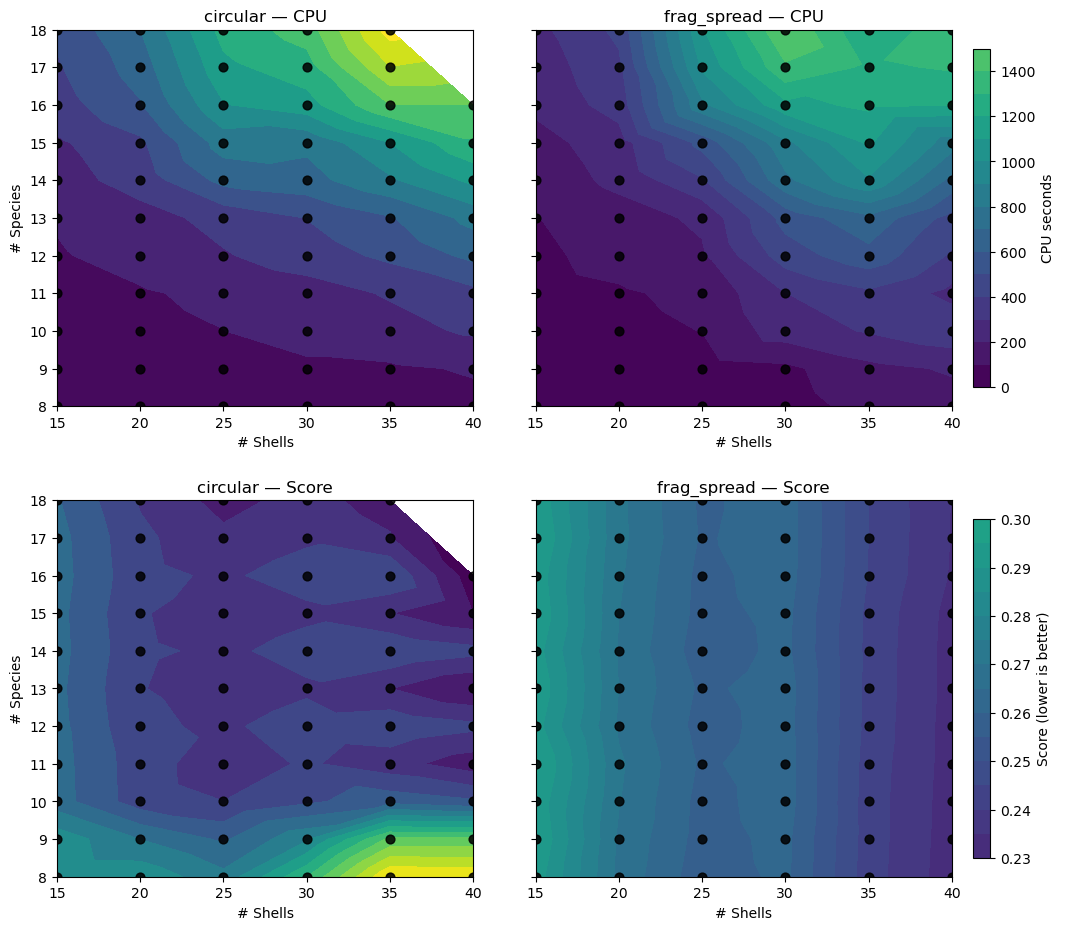

Wrote /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_and_score_contours_grid_linear.png and /Users/indigobrownhall/Code/pyssem/grid_search_new/contours/cpu_and_score_contours_grid_linear.pdf


In [27]:
# --- paths ---
root = '/Users/indigobrownhall/Code/pyssem/grid_search_new'
outdir = f'{root}/contours'

import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

os.makedirs(outdir, exist_ok=True)

# --- load scenario table ---
scn = pd.read_csv(f'{root}/all_scenario_scores_with_cpu.csv')  # simulation_name, Score_scenario, cpu_seconds

def parse_name(name: str):
    mt = name.split('_nshell_')[0]
    m1 = re.search(r'_nshell_(\d+)', name)
    m2 = re.search(r'_sp_(\d+)', name)
    nshells  = int(m1.group(1)) if m1 else np.nan
    nspecies = int(m2.group(1)) if m2 else np.nan
    return mt, nshells, nspecies

p = scn['simulation_name'].apply(parse_name)
scn['model_type'] = [t[0] for t in p]
scn['n_shells']   = [t[1] for t in p]
scn['n_species']  = [t[2] for t in p]

# fallback if n_species not in name but present as a column
if scn['n_species'].isna().all() and 'species_count' in scn.columns:
    scn['n_species'] = scn['species_count']

# clean
scn = scn.dropna(subset=['cpu_seconds','Score_scenario','n_shells','n_species'])
scn['n_shells']  = scn['n_shells'].astype(int)
scn['n_species'] = scn['n_species'].astype(int)

# aggregate duplicates at same (n_shells, n_species) with median
def agg_by_factors(df):
    return (df.groupby(['n_shells','n_species'], as_index=False)
              .agg(cpu_seconds=('cpu_seconds','median'),
                   Score_scenario=('Score_scenario','median')))

circ = agg_by_factors(scn[scn['model_type']=='circular'])
frag = agg_by_factors(scn[scn['model_type']=='frag_spread'])

# consistent axes ticks (union across both types)
x_ticks = sorted(set(circ['n_shells']).union(set(frag['n_shells'])))
y_ticks = sorted(set(circ['n_species']).union(set(frag['n_species'])))

# shared color scales per row
cpu_min = min(circ['cpu_seconds'].min(), frag['cpu_seconds'].min())
cpu_max = max(circ['cpu_seconds'].max(), frag['cpu_seconds'].max())
cpu_norm = Normalize(vmin=float(cpu_min), vmax=float(cpu_max))

sc_min = min(circ['Score_scenario'].min(), frag['Score_scenario'].min())
sc_max = max(circ['Score_scenario'].max(), frag['Score_scenario'].max())
score_norm = Normalize(vmin=float(sc_min), vmax=float(sc_max))

def tricontour(ax, df, zcol, levels=14, norm=None, title=''):
    x = df['n_shells'].to_numpy(float)
    y = df['n_species'].to_numpy(float)
    z = df[zcol].to_numpy(float)
    tri = mtri.Triangulation(x, y)
    cs = ax.tricontourf(tri, z, levels=levels, norm=norm)
    ax.scatter(x, y, s=40, c='k', alpha=0.85)             # evaluated points
    ax.set_xticks(x_ticks); ax.set_yticks(y_ticks)
    ax.set_xlabel('# Shells'); ax.set_title(title)
    return cs

# ---- figure: 2 rows × 2 cols ----
fig, axes = plt.subplots(2, 2, figsize=(14, 11), sharey=True)
fig.subplots_adjust(left=0.18, right=0.95, hspace=0.25, wspace=0.15)

# Top row: CPU
cs_cpu_c = tricontour(axes[0,0], circ, 'cpu_seconds', norm=cpu_norm, title='circular — CPU')
cs_cpu_f = tricontour(axes[0,1], frag, 'cpu_seconds', norm=cpu_norm, title='frag_spread — CPU')
axes[0,0].set_ylabel('# Species')

# Bottom row: Score
cs_sc_c = tricontour(axes[1,0], circ, 'Score_scenario', norm=score_norm, title='circular — Score')
cs_sc_f = tricontour(axes[1,1], frag, 'Score_scenario', norm=score_norm, title='frag_spread — Score')
axes[1,0].set_ylabel('# Species')

# shared colorbars per row
cbar1 = fig.colorbar(cs_cpu_f, ax=axes[0,:], shrink=0.9, pad=0.02)
cbar1.set_label('CPU seconds')
cbar2 = fig.colorbar(cs_sc_f,  ax=axes[1,:], shrink=0.9, pad=0.02)
cbar2.set_label('Score (lower is better)')

# legend outside-left (evaluated points)
# outside_legend = [Line2D([0],[0], marker='o', linestyle='None', color='k', label='evaluated points')]
# axes[0,0].legend(handles=outside_legend, loc='center left',
#                  bbox_to_anchor=(-0.23, 0.5), frameon=False, fontsize=10)

# fig.suptitle('CPU (top) and Score (bottom) contours by model type', y=0.99, fontsize=16)
fn = f'{outdir}/cpu_and_score_contours_grid_linear'
fig.savefig(fn + '.png', dpi=220)
fig.savefig(fn + '.pdf')
plt.show()
print(f"Wrote {fn+'.png'} and {fn+'.pdf'}")

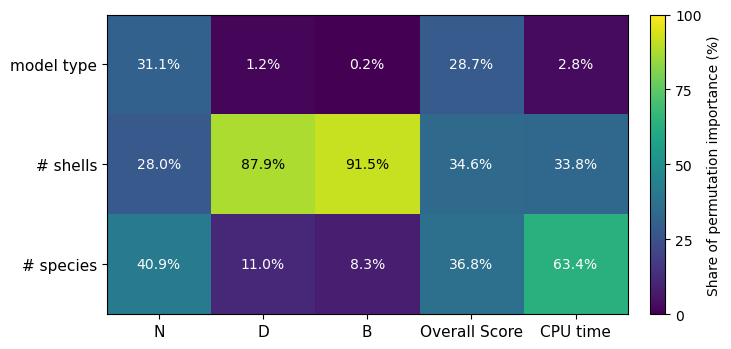

In [40]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

OUT = '/Users/indigobrownhall/Code/pyssem/grid_search_new'

# Load the column-normalized grid if it's not in memory
if 'grid_norm' in globals():
    G = grid_norm.copy()
else:
    G = pd.read_csv(os.path.join(OUT, 'importance_compact_species_plus_totals_percent.csv'), index_col=0)

# Tidy column names / order
G = G.rename(columns={'Score':'Overall Score', 'CPU':'CPU time'})
cols = [c for c in ['N','D','B','Overall Score','CPU time'] if c in G.columns]
G = G[cols]

fig, ax = plt.subplots(figsize=(7.4, 3.6))
im = ax.imshow(G.values.astype(float), vmin=0.0, vmax=1.0, cmap='viridis', aspect='auto')

ax.set_xticks(range(G.shape[1])); ax.set_xticklabels(G.columns, fontsize=11)
ax.set_yticks(range(G.shape[0])); ax.set_yticklabels(['model type', '# shells', '# species'], fontsize=11)

# --- choose text color from per-cell luminance of the colormap ---
def text_color_from_cmap(val, im, thresh=0.58):
    """val in [0,1]; returns 'black' for light cells, 'white' for dark cells."""
    rgba = im.cmap(im.norm(val))         # RGBA in 0..1
    r, g, b = rgba[:3]
    luminance = 0.2126*r + 0.7152*g + 0.0722*b  # perceptual
    return 'black' if luminance >= thresh else 'white'

# annotate
V = G.values.astype(float)
for i in range(V.shape[0]):
    for j in range(V.shape[1]):
        v = V[i, j]
        if np.isfinite(v):
            ax.text(j, i, f"{100*v:.1f}%", ha='center', va='center',
                    fontsize=10, color=text_color_from_cmap(v, im))
        else:
            ax.text(j, i, "n/a", ha='center', va='center', fontsize=10, color='black')

# colorbar (%)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('Share of permutation importance (%)', rotation=90)
cb.set_ticks([0, 0.25, 0.5, 0.75, 1.0]); cb.set_ticklabels(['0','25','50','75','100'])

plt.tight_layout()
fig.savefig(os.path.join(OUT, 'importance_compact_species_plus_totals_heatmap_clean.png'), dpi=220)
fig.savefig(os.path.join(OUT, 'importance_compact_species_plus_totals_heatmap_clean.pdf'))
plt.show()